In [3]:
import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from pathlib import Path 

from shapely import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon, box
from shapely import affinity, difference
from shapely.plotting import plot_line, plot_points, plot_polygon
from tabulate import tabulate

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
file = Path().resolve()
parent, root = file.parent, file.parents[1]

# add the location of the root folder (zeroheliumkit) to the PATH
sys.path.append(str(root))

# Additionally remove the current file's directory from sys.path
try:
    sys.path.remove(str(parent))
except ValueError: # Already removed
    pass

In [5]:
from zeroheliumkit import GeomCollection, SuperStructure, Anchor
from zeroheliumkit import Rectangle, Square, MicroChannels
from zeroheliumkit.fem import *
from zeroheliumkit.src.settings import *
from zeroheliumkit.helpers.constants import *

In [6]:
plot_config = {"box": BLUE,
               "electrode": ORANGE,
               "anchors": RED}

dirname = 'data/'

<Axes: >

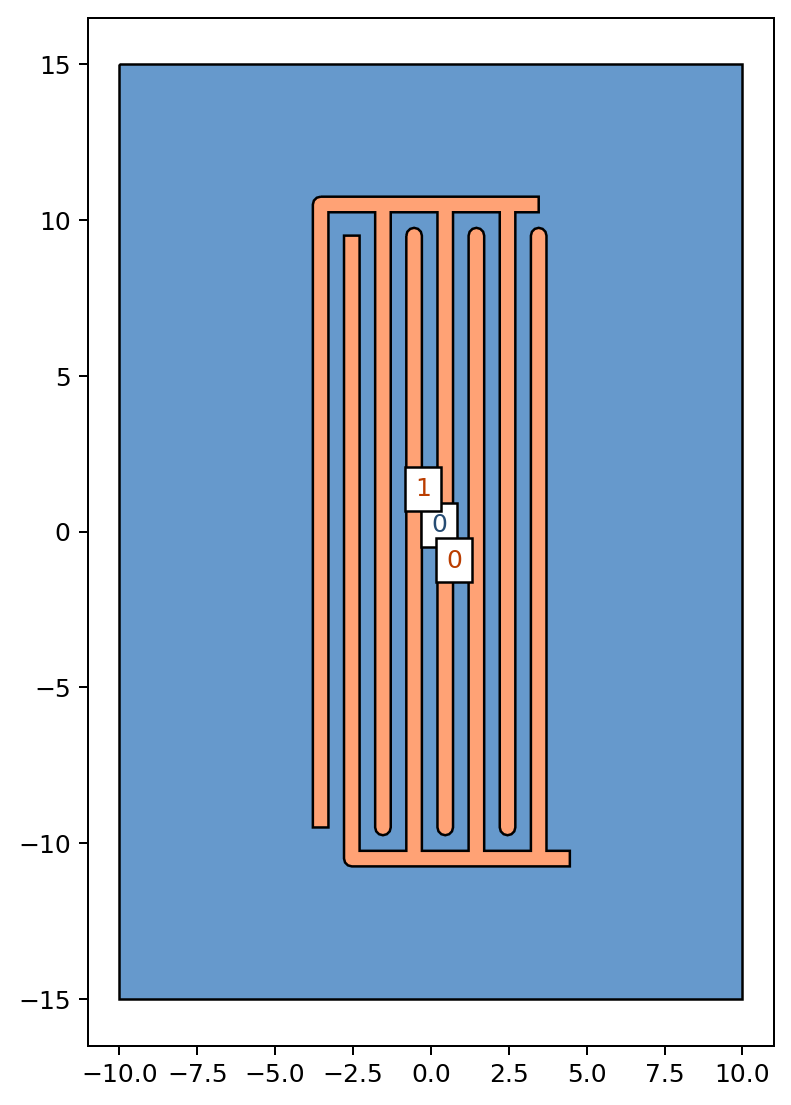

In [7]:
L = 20
s = 2

device = MicroChannels(length=L,
                        spacing=s,
                        num=4,
                        angle=0,
                        layers={"electrode": 0.5})
dm = device.return_mirrored("x")
dm.moveby((s/2, L - s/2))
device.append(dm)
cm = device.electrode.centroid
device.moveby((-cm.x,-cm.y))
device.add_layer("box", Rectangle(20, 30, (0,0)))


device.quickplot(plot_config, show_idx=True)

### **GMSH**

In [8]:
d_metal = 0.1
d_box = 10

""" 
extrude_config: 
key - gmsh layer name
item - gmshLayer_info dict: 
       (geometry layer, z0, thickness, Physical Vol Name, CUT gmsh layer=None, forConstruction=False)
"""
extrude_config = {
    'metal':       gmshLayer_info('electrode', 0, d_metal, 'METAL'),
    'wafer':       gmshLayer_info('box', -d_box/2, d_box/2, 'DIELECTRIC'),
    'vacuum':      gmshLayer_info('box', 0, d_box/2, 'VACUUM', ('metal',))
}

""" 
electrodes_config: 
key - physicalSurface name
item - physSurface_info dict:
       (geometry layer, electrode idx in geometry layer, gmsh layer, 'linked_to'=physicalSurface name - links to specific physSurf name. Defaults 'None')
"""
electrodes_config = {
    'metal1':       physSurface_info('electrode', [0,], 'metal'),
    'metal2':       physSurface_info('electrode', [1,], 'metal')
}

mediumregion_box = [-6, 6, -12, 12, -1, 1]
fineregion_box = [-4, 4, -11, 11, -0.1, 0.2]
scale = 1
mesh_params = (scale * 3, scale * 0.7, scale * 0.1, fineregion_box, mediumregion_box)

In [10]:
msh_filename = 'idc'
meshMKR =  GMSHmaker(layout=device, 
                     extrude_config=extrude_config, 
                     electrodes_config=electrodes_config, 
                     mesh_params=mesh_params)
meshMKR.disable_consoleOutput()
#meshMKR.create_geo(dirname + msh_filename)
meshMKR.create_mesh(dirname + msh_filename, dim=3)
meshMKR.open_gmsh()
meshMKR.finalize()

on 0: mesh is constructed                                                       
on 0: mesh saved                                                                
Gmsh generation |███| 1/1 [100%] in 8.9s (0.11/s)                               


### **FEM**

In [11]:
var_eps = {
        'DIELECTRIC': 3.15,
        'METAL': 1.0,
        'VACUUM': 1.0,
}

ff_config ={
    'meshfile': msh_filename,
    'dielectric_constants': var_eps,
    'ff_polynomial': 2,
    'physicalSurfaces': {k: v.get('group_id') for (k, v) in meshMKR.physicalSurfaces.items()},
    'physicalVolumes': {k: v.get('group_id') for (k, v) in meshMKR.physicalVolumes.items()},
    'extract_opt': [extract_results('Ez', 'xz', (-1.5, 1.5, 71), (-0.5, 0.6, 71), 0),
                    extract_results('phi', 'xz', (-1.5, 1.5, 71), (-0.5, 0.6, 71), 0),
                    extract_results('Cm')
                    ]
}

with open(dirname + r'config.yaml', 'w') as file:
    documents = yaml.safe_dump(ff_config, file)

In [12]:
with open(dirname + r'config.yaml', 'r') as file:
    config = yaml.safe_load(file)

pyff = FreeFEM(config=config,
               dirname=dirname)

In [38]:
pyff.run(print_log=False)

Freefem running |████████████████████████████████████████| 96 in 0.6s (49.67/s)                                         
Freefem calculations are complete


### **Electrostatic potential plots**

In [17]:
ph = FieldAnalyzer((dirname + "phi_xz.txt", 'phi', '2Dmap'),)
ez = FieldAnalyzer((dirname + "Ez_xz.txt", 'Ez', '2Dmap'),)
print(ph.phi.keys())

dict_keys(['metal1', 'metal2', 'xlist', 'ylist'])


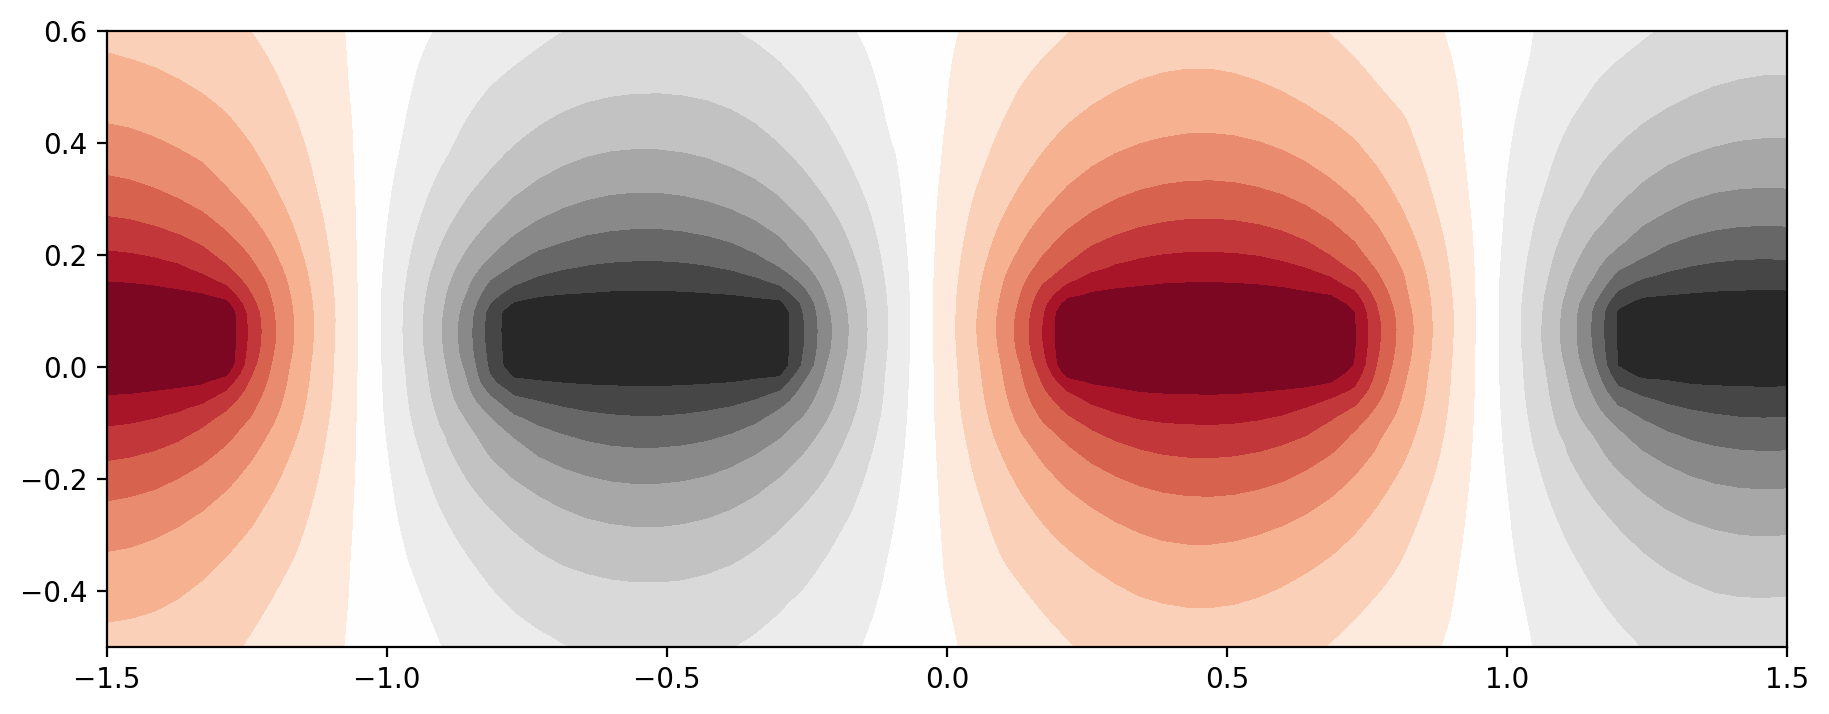

In [19]:
voltages = {
    'metal1':  1,
    'metal2':  0,
}

clist = [GRAY, BLUE, YELLOW2, RED, GREEN, YELLOW]
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)

ph.plot_potential2D(ph.phi, voltages, ax=ax, zero_line=False, cmap='RdGy')
#ez.plot_potential2D(ez.Ez, voltages, ax=ax, zero_line=False, cmap='RdGy')

plt.gca().set_aspect('equal')
plt.show()